# Manual FedAvg — Global Model Evaluation & EDA

Phase 2 — Model Validation Notebook

In this notebook we:

- Load the trained **manual FedAvg global model**
- Load the **merged_hospitals** dataset
- Create a central 80/20 train–test split
- Run predictions on the test set
- Analyze per-class performance
- Visualize the confusion matrix
- Do some quick EDA on the test data


Total rows: 507

Label counts:
Label
2    170
0    170
1    167
Name: count, dtype: int64

Label distribution:
Label
2    0.335306
0    0.335306
1    0.329389
Name: proportion, dtype: float64
=== Classification Report ===
              precision    recall  f1-score   support

           0     1.0000    0.9706    0.9851        34
           1     0.9143    0.9412    0.9275        34
           2     0.9412    0.9412    0.9412        34

    accuracy                         0.9510       102
   macro avg     0.9518    0.9510    0.9513       102
weighted avg     0.9518    0.9510    0.9513       102



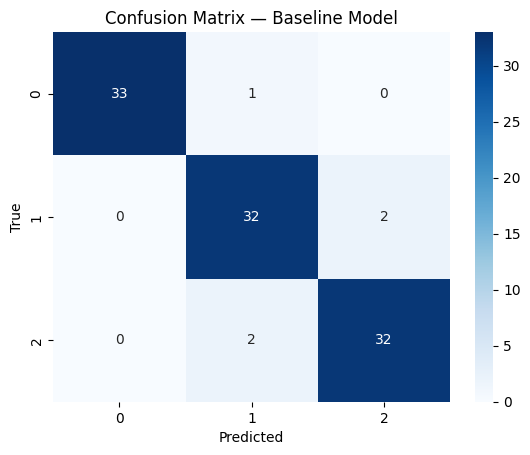

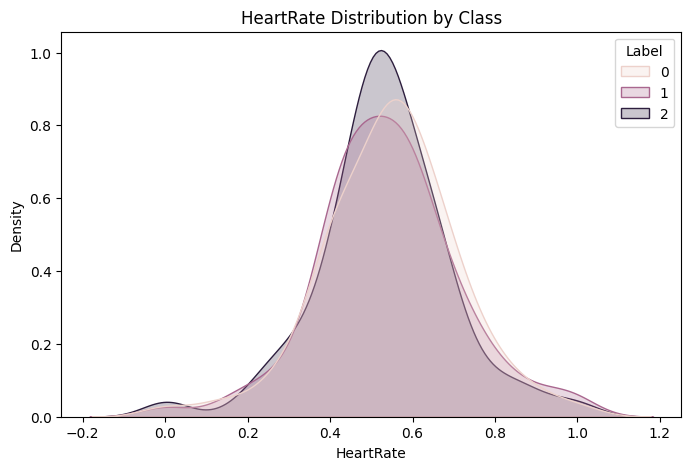

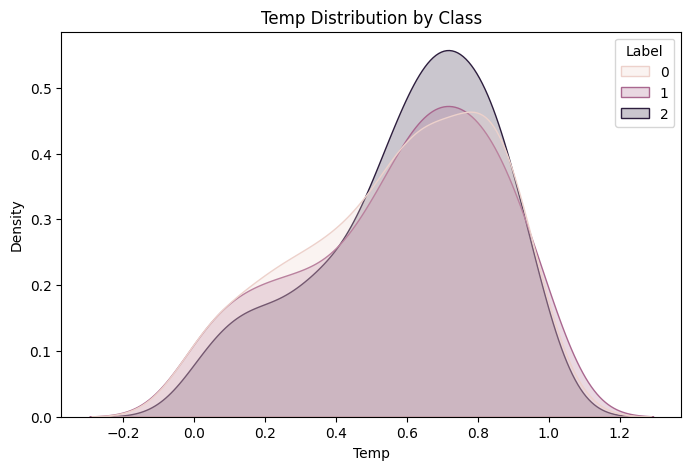

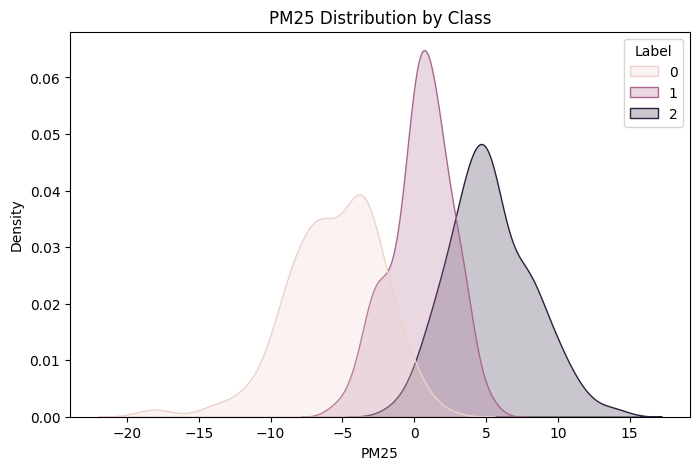

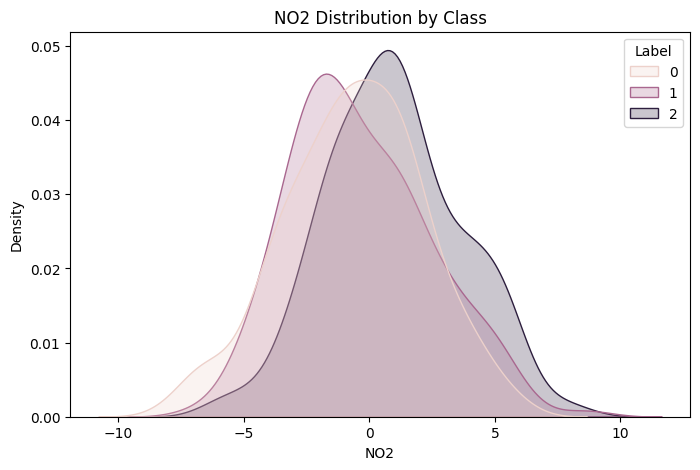

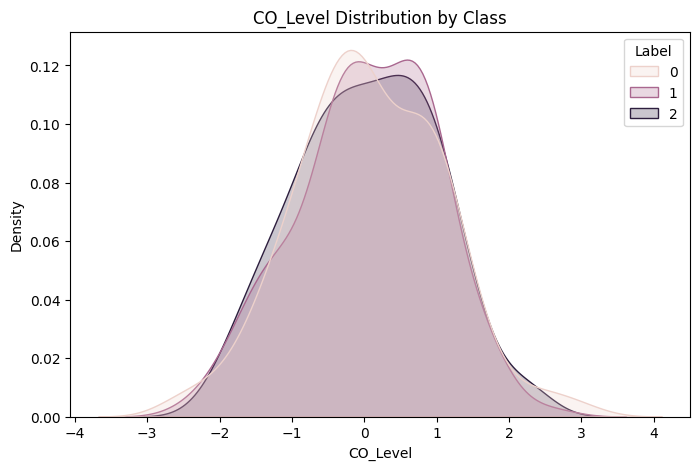

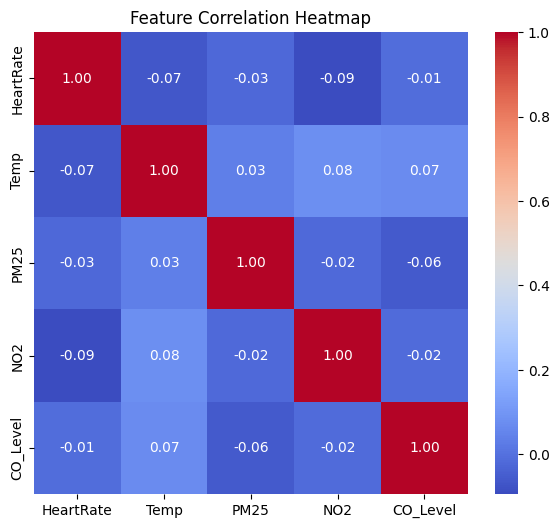

,HeartRate,Temp,PM25,NO2,CO_Level
Label,,,,,
0,0.544770,0.571804,-5.543076,-0.651913,0.063825
1,0.539057,0.581253,0.471962,-0.369355,0.051697
2,0.530673,0.601303,5.298705,0.948042,0.046231


In [10]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import glob

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neural_network import MLPClassifier

# Settings (same as central_baseline.py)
TARGET_COLUMN = "Label"
FEATURE_COLUMNS = ["HeartRate", "Temp", "PM25", "NO2", "CO_Level"]

MERGED_DIR = Path("../data/processed/merged_hospitals")

def load_merged_dataset():
    files = glob.glob(str(MERGED_DIR / "client_merged_*.csv"))
    if not files:
        raise FileNotFoundError(f"❌ No merged client files found in {MERGED_DIR}")

    dfs = [pd.read_csv(f) for f in files]
    df_all = pd.concat(dfs, ignore_index=True)

    df_all = df_all.dropna(subset=FEATURE_COLUMNS + [TARGET_COLUMN]).reset_index(drop=True)
    return df_all


df = load_merged_dataset()
df.head()

print("Total rows:", len(df))
print("\nLabel counts:")
print(df[TARGET_COLUMN].value_counts())

print("\nLabel distribution:")
print(df[TARGET_COLUMN].value_counts(normalize=True))

X = df[FEATURE_COLUMNS].to_numpy().astype("float32")
y = df[TARGET_COLUMN].to_numpy().astype("int32")

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    shuffle=True,
    stratify=y,
    random_state=42
)

X_train.shape, X_test.shape



clf = MLPClassifier(
    hidden_layer_sizes=(32, 32),
    activation="relu",
    solver="adam",
    max_iter=300,
    random_state=42
)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, digits=4))

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap="Blues", fmt="d",
            xticklabels=[0,1,2], yticklabels=[0,1,2])

plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix — Baseline Model")
plt.show()


for col in FEATURE_COLUMNS:
    plt.figure(figsize=(8,5))
    sns.kdeplot(data=df, x=col, hue=TARGET_COLUMN, fill=True)
    plt.title(f"{col} Distribution by Class")
    plt.show()

plt.figure(figsize=(7,6))
sns.heatmap(df[FEATURE_COLUMNS].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

df.groupby(TARGET_COLUMN)[FEATURE_COLUMNS].mean()

